In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  6 10:26:55 2019
Dog v.s Cat
@author: bme-ladm-pliu1
"""
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
from keras.preprocessing.image import load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

Using TensorFlow backend.


In [2]:

print(os.listdir("data"))

FAST_RUN = True
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color

['sampleSubmission.csv', '.DS_Store', 'test', 'train', 'test1.zip', 'train.zip']


In [3]:
# Any results you write to the current directory are saved as output.

filenames = os.listdir("data/train/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
    
df.head()



,filename,category
0,cat.9466.jpg,0
1,dog.243.jpg,1
2,cat.10925.jpg,0
3,cat.5007.jpg,0
4,dog.12201.jpg,1


In [4]:
df.tail()

,filename,category
24995,dog.8214.jpg,1
24996,dog.6659.jpg,1
24997,dog.5095.jpg,1
24998,dog.9610.jpg,1
24999,cat.4971.jpg,0


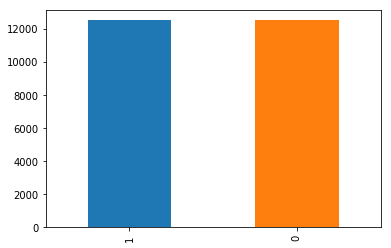

In [5]:
#See Total In count
df['category'].value_counts().plot.bar()


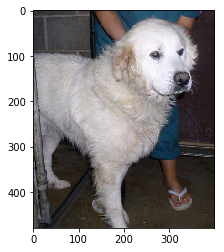

In [6]:
#See sample image
sample = random.choice(filenames)
image = load_img("data/train/"+sample)
plt.imshow(image)


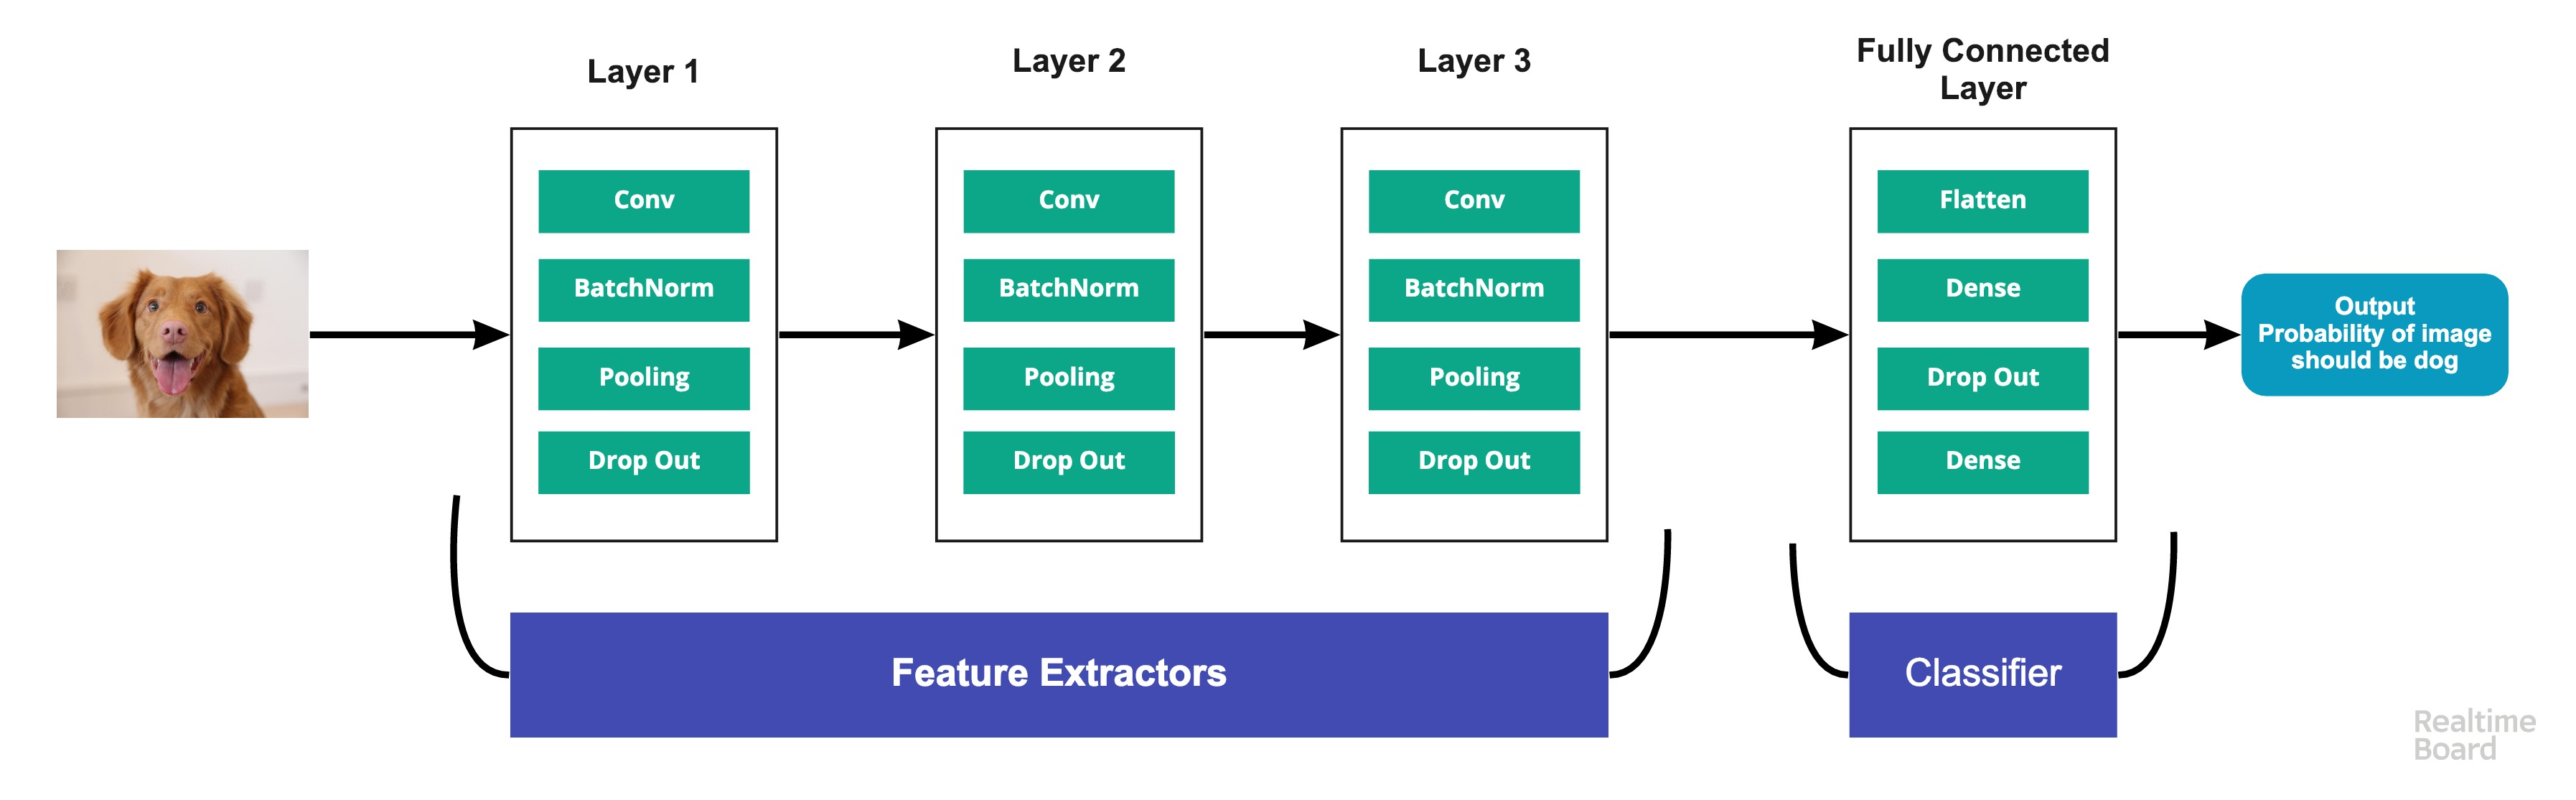

In [7]:
#Build Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [8]:
#Callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#
#Early Stop
#To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

earlystop = EarlyStopping(patience=10)

#Learning Rate Reduction
#We will reduce the learning rate when then accuracy not increase for 2 steps

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


checkpoint = ModelCheckpoint('./dogvscatmodel_ck.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

callbacks = [earlystop, learning_rate_reduction, checkpoint]

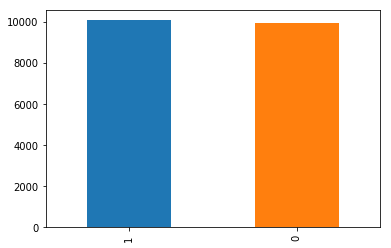

In [9]:
#Prepare Test and Train Data
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()
validate_df['category'].value_counts().plot.bar()

total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [10]:
#Traning Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 20000 images belonging to 2 classes.


In [11]:
#Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)


Found 5000 images belonging to 2 classes.


Found 1 images belonging to 1 classes.


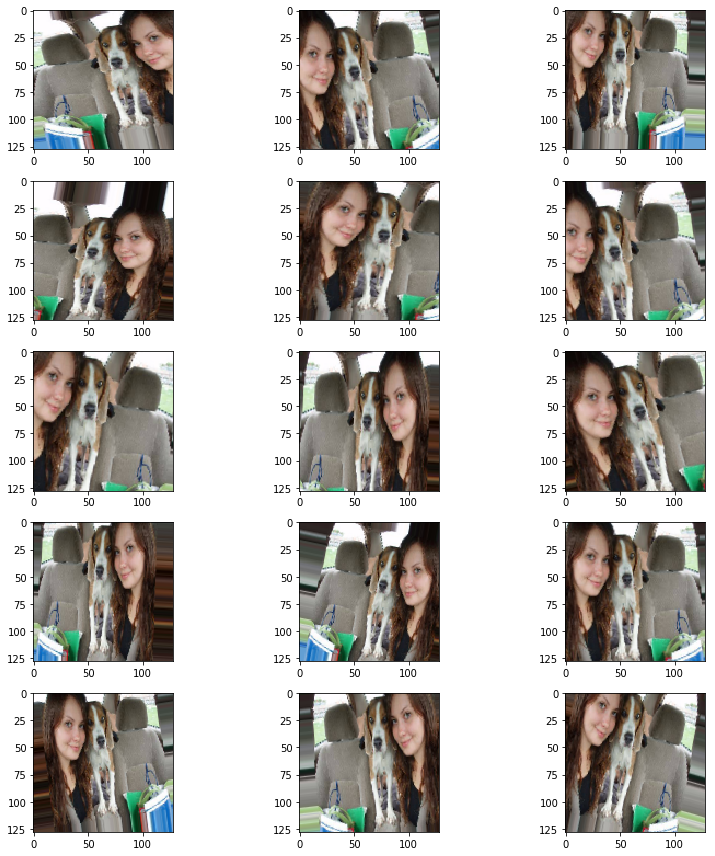

In [12]:
#See how our generator work
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()


In [13]:
#Fit Model
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/3
1333/1333 [==============================] - 371s 278ms/step - loss: 0.7116 - acc: 0.6361 - val_loss: 0.6705 - val_acc: 0.6687

Epoch 00001: val_acc improved from -inf to 0.66867, saving model to ./dogvscatmodel_ck.h5
Epoch 2/3
1333/1333 [==============================] - 137s 103ms/step - loss: 0.5310 - acc: 0.7368 - val_loss: 0.6248 - val_acc: 0.6568

Epoch 00002: val_acc did not improve from 0.66867
Epoch 3/3
1333/1333 [==============================] - 135s 102ms/step - loss: 0.4877 - acc: 0.7674 - val_loss: 0.4665 - val_acc: 0.7952

Epoch 00003: val_acc improved from 0.66867 to 0.79519, saving model to ./dogvscatmodel_ck.h5


In [14]:
# serialize model network structure to JSON
model_json = model.to_json()
with open("dogvscatmodel.json", "w") as json_file:
    json_file.write(model_json)
#Save Model weights
model.save_weights("dogvscatmodel.h5")

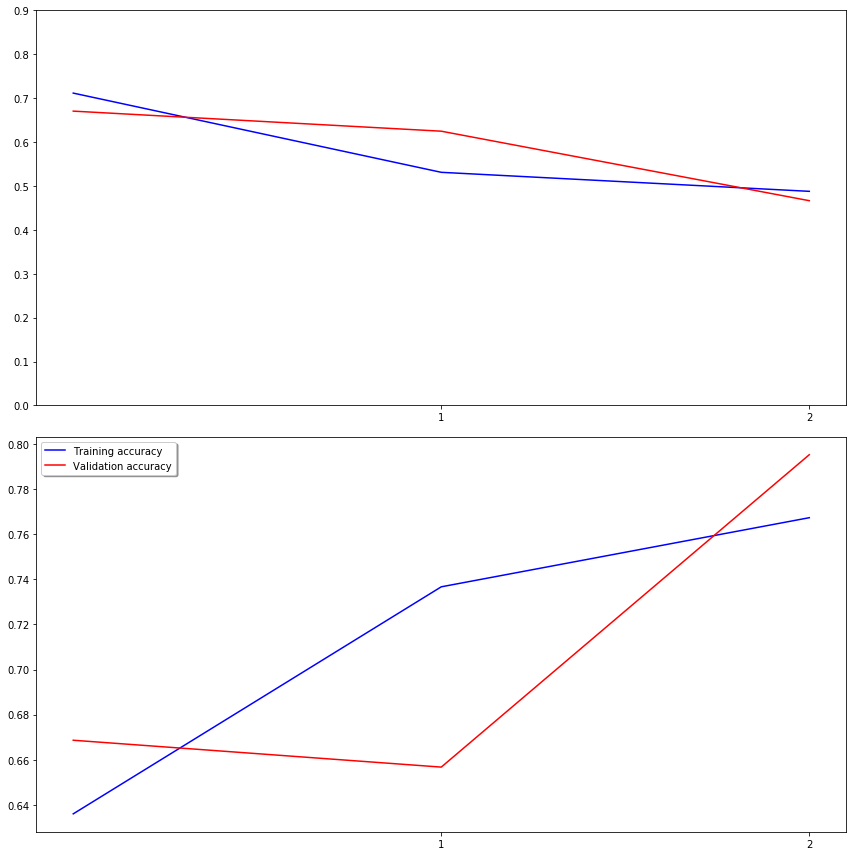

In [15]:
#Virtualize Training
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [16]:
#Prepare Testing Data
test_filenames = os.listdir("data/test/")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [17]:
#Create Testing Generator
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "data/test/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)


Found 12500 images.


In [18]:
#Predict
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

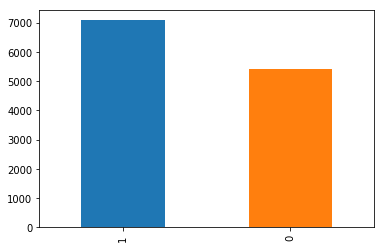

In [19]:
#As predicted of binary classification result return probability that image likely to be a dog. 
#So we will have threshold 0.5 which mean if predicted value more than 50% it is a dog and under 50% will be a cat.

threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)


#Virtaulize Result
test_df['category'].value_counts().plot.bar()

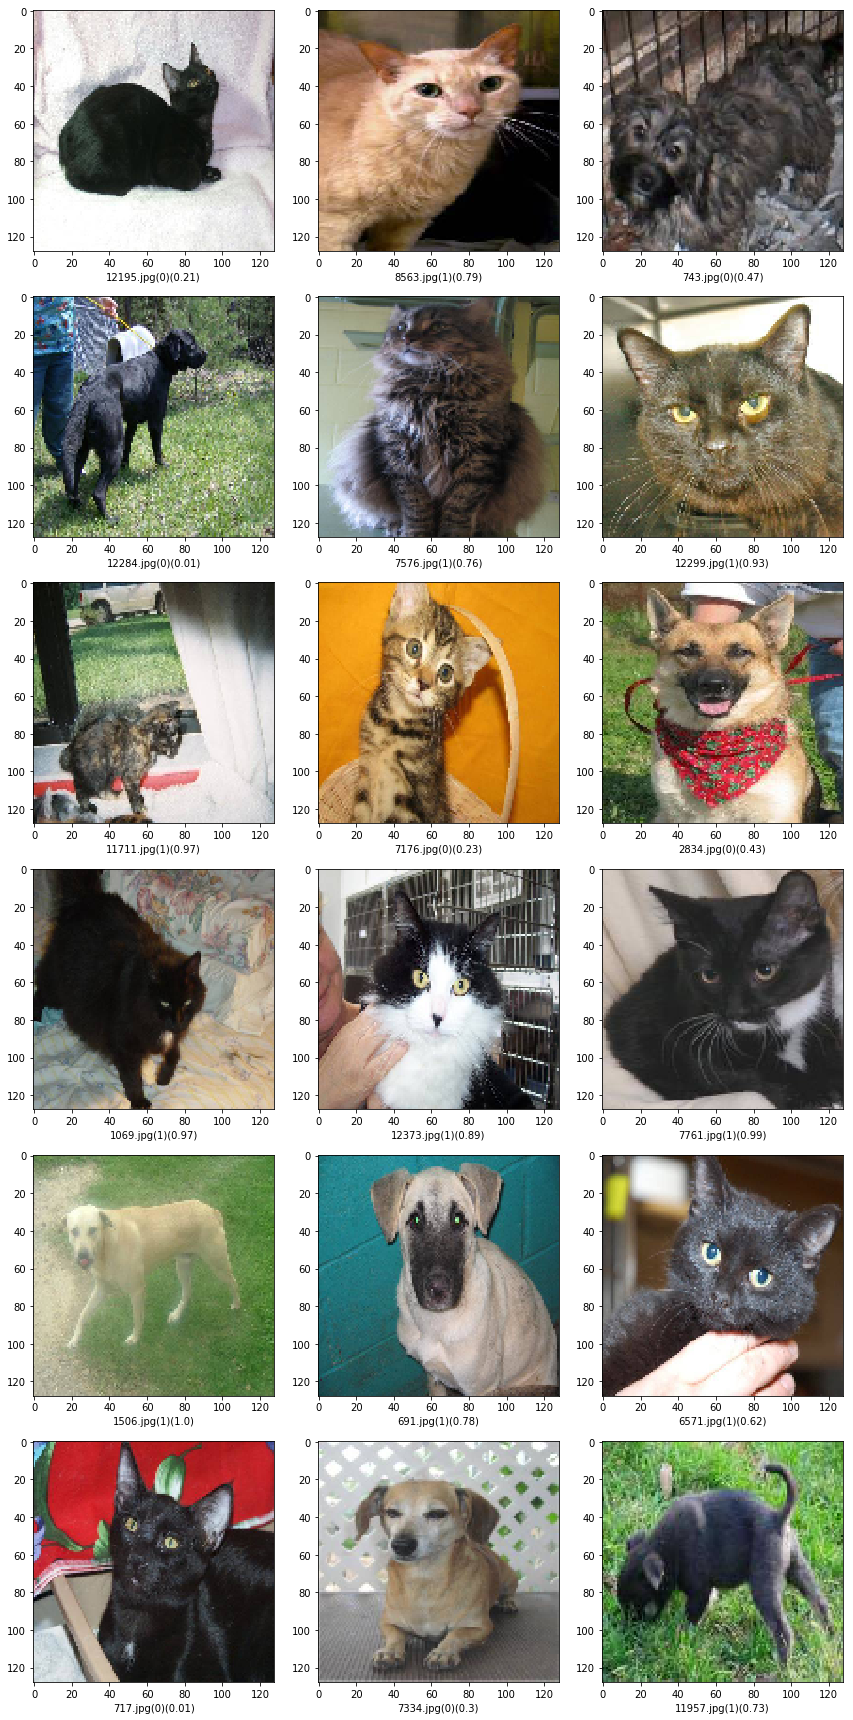

In [20]:
#See predicted result with images
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    probability = row['probability']
    img = load_img("data/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' '(' + "{}".format(round(probability, 2)) + ')')
plt.tight_layout()
plt.show()


In [21]:
#Submission
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)